In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
sys.path.append(r'src/')
from KMeans import StandardScaler, EuclideanKMeans, elbow_method_with_knee

In [2]:
sc = StandardScaler()
latent = np.load(r"Data_preprocessed\hinoki_latent_pca.npy")
latent_sc = sc.fit_transform(latent)
latent_sc_tensor = torch.tensor(latent_sc, dtype=torch.float32)

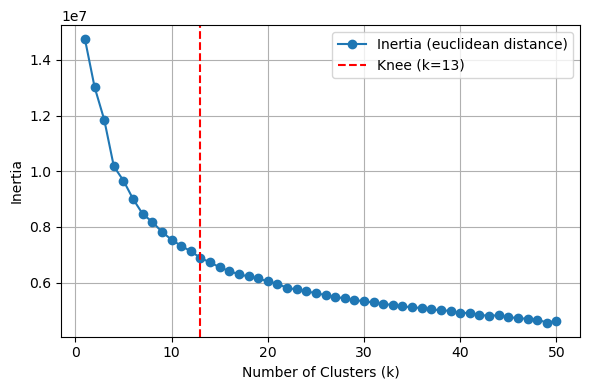

In [ ]:
optimal_k, inertias = elbow_method_with_knee(latent_sc_tensor, k_range=range(1, 51), random_state=42, type='euclidean')

plt.figure(figsize=(6, 4))
plt.plot(range(1, 51), inertias, 'o-', label='Inertia')
if optimal_k is not None:
    plt.axvline(optimal_k, color='red', linestyle='--', label=f"Knee (k={optimal_k})")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.ylim(0.2, 1.5)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(fr'Results\PCA_elbow.png', dpi=300)

In [4]:
km = EuclideanKMeans(n_clusters=optimal_k, random_state=42, device='cuda')
labels = km.fit_predict(latent_sc_tensor)
np.save(r'Data_preprocessed\PCA_km_labels.npy', labels)

---

In [5]:
wavenumber = np.load(r'Data_preprocessed\wavenumber.npy')
ref = np.load(r"Data_preprocessed\hinoki.npy")
original = np.load(r'Data_preprocessed\hinoki_snv.npy')
s1_mask = np.load(r'Data_preprocessed\s1_mask.npy')
s2_2_1_mask = np.load(r'Data_preprocessed\s2_2_1_mask.npy')
s2_2_2_mask = np.load(r'Data_preprocessed\s2_2_2_mask.npy')
s3_mask = np.load(r'Data_preprocessed\s3_mask.npy')
s4_2_1_mask = np.load(r'Data_preprocessed\s4_2_1_mask.npy')
s4_2_2_mask = np.load(r'Data_preprocessed\s4_2_2_mask.npy')

In [6]:
hinoki_mask = np.concatenate([s1_mask.reshape(-1), s2_2_1_mask.reshape(-1), s2_2_2_mask.reshape(-1),
                              s3_mask.reshape(-1), s4_2_1_mask.reshape(-1), s4_2_2_mask.reshape(-1)], axis=0)
hinoki_mask = hinoki_mask.astype(int)

In [7]:
all = np.full_like(hinoki_mask, -1)
all[hinoki_mask == 1] = labels

In [8]:
def make_imglist(all):

    h, w = 1198, 320
    size = h * w

    s1 = all[0 * size : 1 * size].reshape(h, w)
    s2_2_1 = all[1 * size : 2 * size].reshape(h, w)
    s2_2_2 = all[2 * size : 3 * size].reshape(h, w)
    s3 = all[3 * size : 4 * size].reshape(h, w)
    s4_2_1 = all[4 * size : 5 * size].reshape(h, w)
    s4_2_2 = all[5 * size : 6 * size].reshape(h, w)

    img_list = [s1, s2_2_1, s2_2_2, s3, s4_2_1, s4_2_2]
    return img_list

In [9]:
label_list = make_imglist(all)

In [10]:
from matplotlib.colors import ListedColormap

jet_discrete = plt.cm.jet(np.linspace(0, 1, labels.max() - labels.min()+1))
colors_with_black = np.vstack([[1, 1, 1, 1], jet_discrete])
cmap = ListedColormap(colors_with_black)

In [11]:
def plot_label(label_list):
    fig, ax = plt.subplots(1, 6, figsize=(15, 7.5))
    ax = ax.flatten()
    im = None
    vmin = -1
    vmax = int(max(label.max() for label in label_list))

    for i, label in enumerate(label_list):
        im = ax[i].imshow(label, cmap=cmap, vmin=vmin, vmax=vmax)
        ax[i].axis('off')

    plt.tight_layout(rect=[0, 0, 0.96, 1])

    cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.03, pad=0.02)
    cbar.set_label("Cluster Number", fontsize=12)

    # 整数だけに制限（vmin〜vmax）
    cbar.set_ticks(np.arange(vmin, vmax + 1))

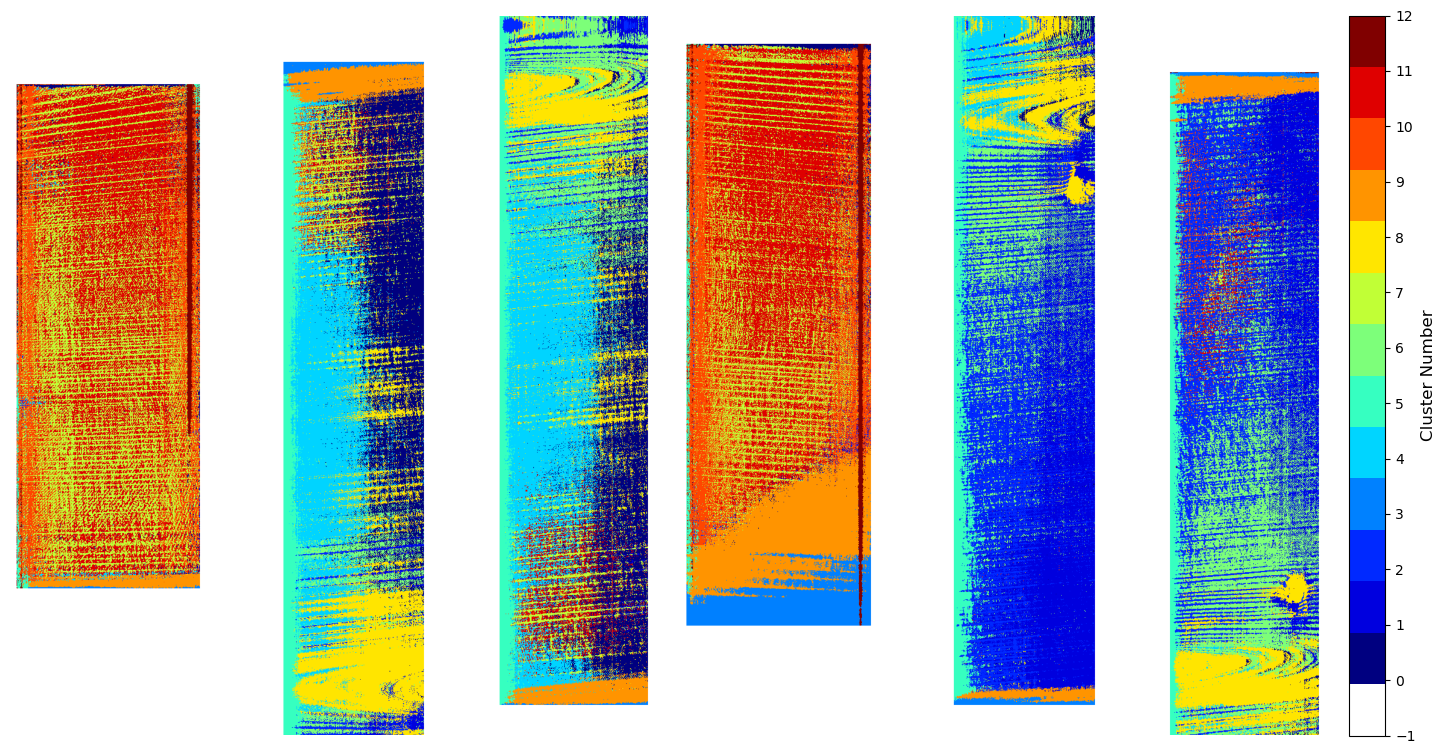

In [12]:
plot_label(label_list);
plt.savefig(fr'Results\PCA_results.png', dpi=300)

In [13]:
class_list = []
for i in np.unique(labels):
    class_list.append(ref[labels == i].mean(axis=0))

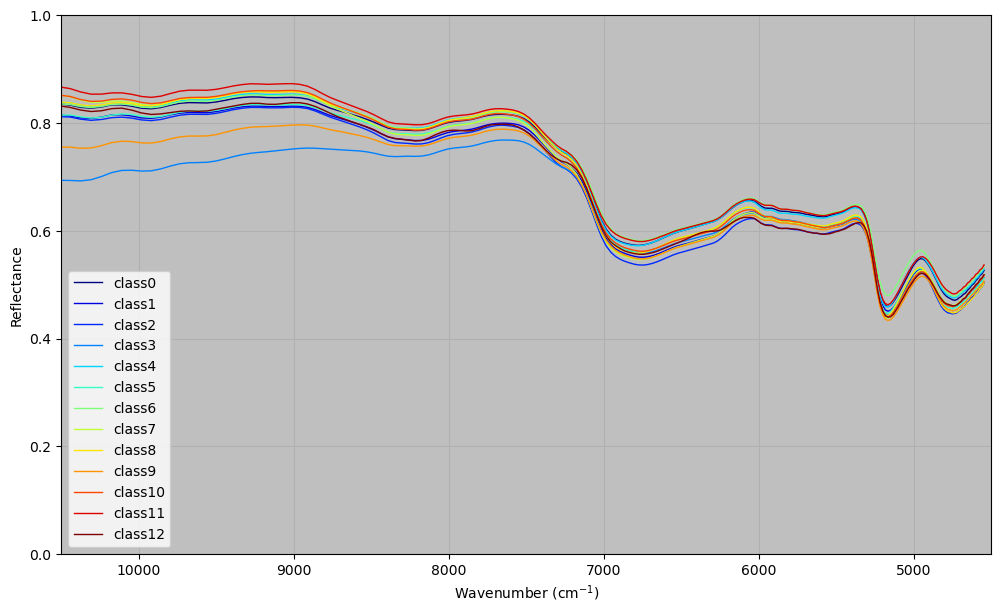

In [14]:
plt.figure(figsize=(12, 7))
for idx, content in enumerate(class_list):
    plt.plot(wavenumber, content, c=cmap.colors[idx+1], lw=1, label=f'class{idx}')
plt.ylabel('Reflectance')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylim(0, 1)
plt.xlim(4500, 10500)
plt.gca().invert_xaxis()
plt.legend(loc='lower left')
plt.gca().set_facecolor("#C0BFBF")
plt.grid(True);
plt.savefig(fr'Results\PCA_ref.png', dpi=300)

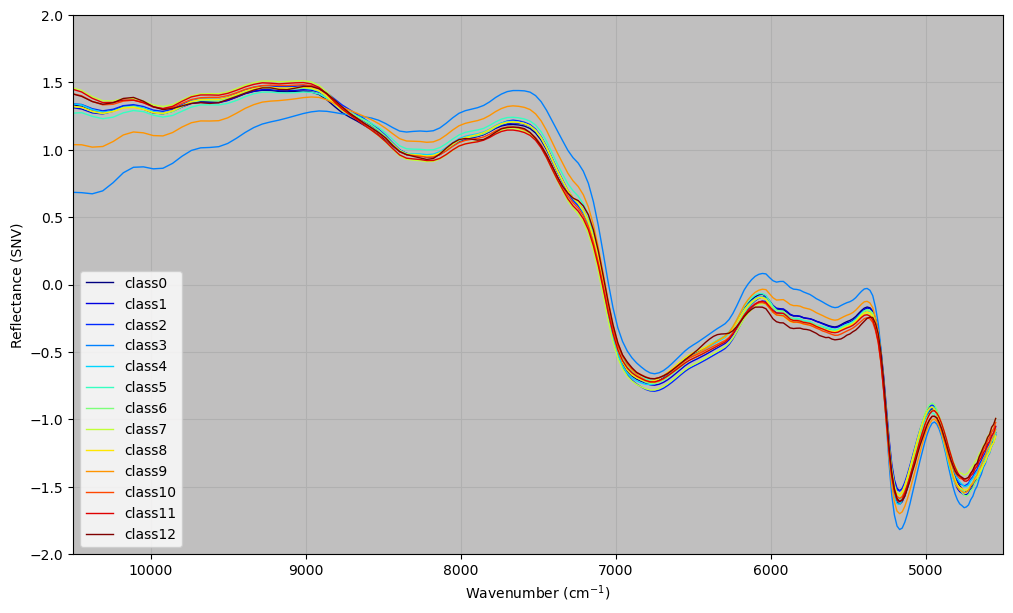

In [15]:
class_snv_list = []
for i in np.unique(labels):
    class_snv_list.append(original[labels == i].mean(axis=0))
plt.figure(figsize=(12, 7))
for idx, content in enumerate(class_snv_list):
    plt.plot(wavenumber, content,  c=cmap.colors[idx+1], lw=1, label=f'class{idx}')
plt.ylabel('Reflectance (SNV)')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylim(-2, 2)
plt.xlim(4500, 10500)
plt.gca().invert_xaxis()
plt.legend(loc='lower left')
plt.gca().set_facecolor("#C0BFBF")
plt.grid(True);
plt.savefig(fr'Results\PCA_snv.png', dpi=300)

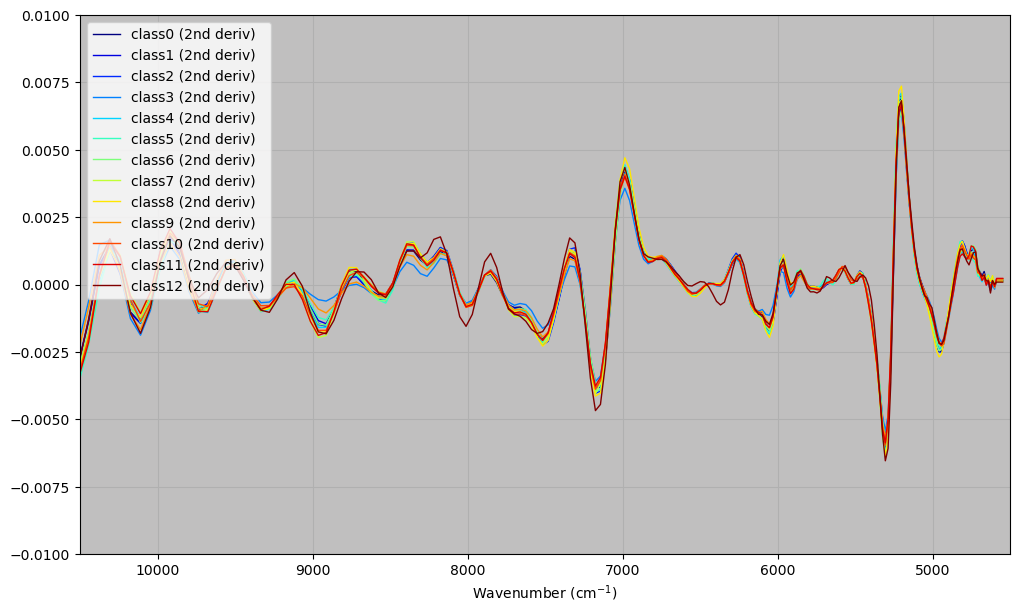

In [16]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" # なんかバッティングする
from scipy.signal import savgol_filter

# パラメータ設定
window_length = 7   # 奇数で、スペクトル分解能とのバランスを見て適宜調整
polyorder = 2       # 多項式の次数（通常 2 または 3）
deriv_order = 2     # 2次微分

class_list_dd = []
for i in class_list:
    class_list_dd.append(savgol_filter(i, window_length, polyorder, deriv=deriv_order))

plt.figure(figsize=(12, 7))
for idx, content in enumerate(class_list_dd):
    plt.plot(wavenumber, content,  c=cmap.colors[idx+1], lw=1, label=f'class{idx} (2nd deriv)')
plt.ylim(-0.01, 0.01)
plt.xlim(4500, 10500)
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.gca().invert_xaxis()
plt.legend(loc='upper left')
plt.gca().set_facecolor("#C0BFBF")
plt.grid(True);
plt.savefig(fr'Results\PCA_sg.png', dpi=300)